In [ ]:

# the covid-19 dataset from Jp cohens repository can be found  here
!wget http://cb.lk/covid_19

!unzip covid_19

!pip install image-classifiers==0.2.2
!pip install image-classifiers==1.0.0b1
!pip install git+https://github.com/qubvel/classification_models.git
!pip install squeezenet
!pip install squeezenet-tensorflow

# the pneumonia dataset from the kaggle repository in our paper was uploaded to google drive and then our  model was trained on it
#  the penumonia data can be found here https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Access the dataset folder
dataset_dir = '/content/drive/My Drive/chest_xray'


--2024-05-04 06:03:20--  http://cb.lk/covid_19
Resolving cb.lk (cb.lk)... 104.21.72.203, 172.67.187.81, 2606:4700:3031::6815:48cb, ...
Connecting to cb.lk (cb.lk)|104.21.72.203|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/s/7rjw6oet4za01op/CovidDataset-20200427T133042Z-001.zip?dl=0 [following]
--2024-05-04 06:03:22--  https://www.dropbox.com/s/7rjw6oet4za01op/CovidDataset-20200427T133042Z-001.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.80.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.80.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/7rjw6oet4za01op/CovidDataset-20200427T133042Z-001.zip [following]
--2024-05-04 06:03:22--  https://www.dropbox.com/s/raw/7rjw6oet4za01op/CovidDataset-20200427T133042Z-001.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc40c

# New section

In [ ]:


# Define a function to create common structure for COVID-19 model
def common_structure_covid(inputs):
    x = GlobalAveragePooling2D()(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)
    return x

# Define a function to create common structure for pneumonia model
def common_structure_pneumonia(inputs):
    x = GlobalAveragePooling2D()(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)
    return x



In [ ]:
import tensorflow as tf
# Define MetricsCallback function
class MetricsCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs['val_accuracy'] > 0.984:
            print("Validation accuracy reached more than 98.33%. Stopping training.")
            self.model.stop_training = True
        val_precision = logs.get('val_precision')
        val_specificity = logs.get('val_specificity_at_sensitivity')
        val_recall = logs.get('val_recall')
        val_auc = logs.get('val_auc')

        val_precision_str = f'{val_precision:.4f}' if val_precision is not None else 'N/A'
        val_specificity_str = f'{val_specificity:.4f}' if val_specificity is not None else 'N/A'
        val_recall_str = f'{val_recall:.4f}' if val_recall is not None else 'N/A'
        val_auc_str = f'{val_auc:.4f}' if val_auc is not None else 'N/A'

        print(f'Precision: {val_precision_str}, Specificity: {val_specificity_str}, Recall: {val_recall_str}, AUC: {val_auc_str}')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import keras
# import classification_models
import numpy as np
import cv2

import PIL.Image as Image
import os

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.applications import ResNet50
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import *
from keras.models import *
from keras.preprocessing import image
# from keras_applications.resnet import resnet34
import tensorflow
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.applications.inception_v3 import InceptionV3
from classification_models.keras import Classifiers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.densenet import DenseNet201, DenseNet169, DenseNet121,  preprocess_input, decode_predictions
# from tensorflow.keras.applications import AlexNet
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.metrics import Precision, SpecificityAtSensitivity, Recall, AUC


# Lists to store the metrics for each fold
covid_metrics = []
pneumonia_metrics = []


# First Layer: COVID-19 Dataset
covid_model = DenseNet169(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for i, layer in enumerate(covid_model.layers):
    layer._name = 'Covid_' + layer.name

for layer in covid_model.layers:
    layer.trainable = False

x1 = common_structure_covid(covid_model.output)
output_covid = Dense(1, activation='sigmoid', name='output_covid')(x1)

# Second Layer: Pneumonia Dataset
pneumonia_model = DenseNet169(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for i, layer in enumerate(pneumonia_model.layers):
    layer._name = 'pneumonia_' + layer.name


for layer in pneumonia_model.layers:
    layer.trainable = False

x2 = common_structure_pneumonia(pneumonia_model.output)
output_pneumonia = Dense(1, activation='sigmoid', name='output_pneumonia')(x2)

# Name the models
covid_model._name = 'covid_densenet169'
pneumonia_model._name = 'pneumonia_densenet169'


covid_model_instance = Model(inputs=covid_model.input, outputs=output_covid)
pneumonia_model_instance = Model(inputs=pneumonia_model.input, outputs=output_pneumonia)

# Compile each model separately
covid_model_instance.compile(loss='binary_crossentropy',
                              optimizer=Adam(lr=0.001),
                              metrics=['accuracy',
                                       Precision(),
                                       SpecificityAtSensitivity(0.5),
                                       Recall(),
                                       AUC()])

pneumonia_model_instance.compile(loss='binary_crossentropy',
                                  optimizer=Adam(lr=0.001),
                                  metrics=['accuracy',
                                           Precision(),
                                           SpecificityAtSensitivity(0.5),
                                           Recall(),
                                           AUC()])



51877672/51877672 [==============================] - 2s 0us/step


In [ ]:
covid_train_datagen = image.ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.15,
    horizontal_flip = True, # can't do vertical flip as it'll completely change the image

    width_shift_range=0.2,
    height_shift_range=0.2,

    #****************************************** newly added ******************************************
    rotation_range=20,
    brightness_range=[0.5, 1.5],

    #****************************************** newly added ******************************************
    channel_shift_range=20,
    preprocessing_function=lambda x: x + tf.random.normal(tf.shape(x), mean=0.0, stddev=noise_level, dtype=tf.float32))

pneumonia_train_datagen = image.ImageDataGenerator(

    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.15,
    horizontal_flip = True, # can't do vertical flip as it'll completely change the image

    width_shift_range=0.2,
    height_shift_range=0.2,

    #****************************************** newly added ******************************************
    rotation_range=20,
    brightness_range=[0.5, 1.5],

    #****************************************** newly added ******************************************
    channel_shift_range=20,
    preprocessing_function=lambda x: x + tf.random.normal(tf.shape(x), mean=0.0, stddev=noise_level, dtype=tf.float32)
)

covid_validation_datagen = image.ImageDataGenerator(rescale=1./255)
pneumonia_validation_datagen = image.ImageDataGenerator(rescale=1./255)

# Create generators for COVID-19 dataset
covid_train_generator = covid_train_datagen.flow_from_directory(
    'CovidDataset/Train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    classes=['Covid', 'Normal']
)

covid_validation_generator = covid_validation_datagen.flow_from_directory(
    'CovidDataset/Val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    classes=['Covid', 'Normal']
)

# Create generators for Pneumonia dataset
pneumonia_train_generator = pneumonia_train_datagen.flow_from_directory(
    '/content/drive/My Drive/chest_xray/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    classes=['NORMAL', 'PNEUMONIA']
)
# chest_xray/train
# covid_dataset_dir = '/content/chest_xray/train'
pneumonia_validation_generator = pneumonia_validation_datagen.flow_from_directory(
    '/content/drive/My Drive/chest_xray/val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    classes=['NORMAL', 'PNEUMONIA']
)


Found 224 images belonging to 2 classes.
Found 60 images belonging to 2 classes.
Found 468 images belonging to 2 classes.
Found 120 images belonging to 2 classes.


In [ ]:

from sklearn.model_selection import KFold
noise_level = 0.1
# Define the number of folds for cross-validation
num_folds = 5
kf = KFold(n_splits=num_folds)

# Lists to store the metrics for each fold
covid_metrics = []
pneumonia_metrics = []

# Iterate over the folds
for train_index, val_index in kf.split(covid_train_generator):
    # Fetch the training data for the current fold
    train_data = next(covid_train_generator)
    train_images, train_labels = train_data[0], train_data[1]

    # Fetch the validation data for the current fold
    val_data = next(covid_validation_generator)
    val_images, val_labels = val_data[0], val_data[1]

    # Train the COVID-19 model on the current fold
    covid_model_instance.fit(
        train_images,
        train_labels,
        epochs=15,
        validation_data=(val_images, val_labels),
        callbacks=[MetricsCallback()]
    )

    # Evaluate the COVID-19 model and store the metrics
    covid_metrics.append(covid_model_instance.evaluate(val_images, val_labels))



Epoch 1/15
1/1 [==============================] - 30s 30s/step - loss: 0.9369 - accuracy: 0.5938 - precision: 0.6875 - specificity_at_sensitivity: 0.6154 - recall: 0.5789 - auc: 0.5628 - val_loss: 0.6779 - val_accuracy: 0.4688 - val_precision: 0.4333 - val_specificity_at_sensitivity: 0.8421 - val_recall: 1.0000 - val_auc: 0.8360
Epoch 2/15
1/1 [==============================] - 18s 18s/step - loss: 0.7179 - accuracy: 0.6250 - precision: 0.6842 - specificity_at_sensitivity: 0.7692 - recall: 0.6842 - auc: 0.6194 - val_loss: 0.6468 - val_accuracy: 0.5312 - val_precision: 0.4643 - val_specificity_at_sensitivity: 1.0000 - val_recall: 1.0000 - val_auc: 0.9737
Epoch 3/15
1/1 [==============================] - 18s 18s/step - loss: 0.8691 - accuracy: 0.4375 - precision: 0.5333 - specificity_at_sensitivity: 0.4615 - recall: 0.4211 - auc: 0.4838 - val_loss: 0.6222 - val_accuracy: 0.5938 - val_precision: 0.5000 - val_specificity_at_sensitivity: 1.0000 - val_recall: 1.0000 - val_auc: 0.9980
Epoch 4

In [ ]:
# Lists to store the metrics for each fold for pneumonia model
pneumonia_metrics = []

# Iterate over the folds
for train_index, val_index in kf.split(pneumonia_train_generator):
    # Fetch the training data for the current fold for pneumonia model
    pneumonia_train_data = next(pneumonia_train_generator)
    pneumonia_train_images, pneumonia_train_labels = pneumonia_train_data[0], pneumonia_train_data[1]

    # Fetch the validation data for the current fold for pneumonia model
    pneumonia_val_data = next(pneumonia_validation_generator)
    pneumonia_val_images, pneumonia_val_labels = pneumonia_val_data[0], pneumonia_val_data[1]

    # Train the Pneumonia model on the current fold
    pneumonia_model_instance.fit(
        pneumonia_train_images,
        pneumonia_train_labels,
        epochs=15,
        validation_data=(pneumonia_val_images, pneumonia_val_labels),
        callbacks=[MetricsCallback()]
    )

    # Evaluate the Pneumonia model and store the metrics
    pneumonia_metrics.append(pneumonia_model_instance.evaluate(pneumonia_val_images, pneumonia_val_labels))


Epoch 1/15
1/1 [==============================] - 34s 34s/step - loss: 1.4151 - accuracy: 0.2812 - precision_1: 0.2222 - specificity_at_sensitivity_1: 0.2105 - recall_1: 0.3077 - auc_1: 0.2672 - val_loss: 0.7194 - val_accuracy: 0.4062 - val_precision_1: 0.0000e+00 - val_specificity_at_sensitivity_1: 0.6667 - val_recall_1: 0.0000e+00 - val_auc_1: 0.6255
Epoch 2/15
1/1 [==============================] - 18s 18s/step - loss: 0.9706 - accuracy: 0.4688 - precision_1: 0.3889 - specificity_at_sensitivity_1: 0.4211 - recall_1: 0.5385 - auc_1: 0.4818 - val_loss: 0.6893 - val_accuracy: 0.4688 - val_precision_1: 0.5000 - val_specificity_at_sensitivity_1: 0.7333 - val_recall_1: 0.1176 - val_auc_1: 0.7176
Epoch 3/15
1/1 [==============================] - 14s 14s/step - loss: 0.8460 - accuracy: 0.5312 - precision_1: 0.4375 - specificity_at_sensitivity_1: 0.6316 - recall_1: 0.5385 - auc_1: 0.5506 - val_loss: 0.6718 - val_accuracy: 0.5312 - val_precision_1: 0.6667 - val_specificity_at_sensitivity_1: 0

In [ ]:
# covid results
noise_level = 0.1
covid_history = covid_model_instance.fit(
    covid_train_generator,
    epochs=15,
    # steps_per_epoch=len(covid_train_generator),
    validation_data=covid_validation_generator,
    # validation_steps=len(covid_validation_generator),
    callbacks=[MetricsCallback()]
)

Epoch 1/15
7/7 [==============================] - 92s 11s/step - loss: 0.7425 - accuracy: 0.6384 - precision_2: 0.6566 - specificity_at_sensitivity_2: 0.7768 - recall_2: 0.5804 - auc_2: 0.6654 - val_loss: 0.5519 - val_accuracy: 0.6500 - val_precision_2: 0.5882 - val_specificity_at_sensitivity_2: 1.0000 - val_recall_2: 1.0000 - val_auc_2: 0.9900
Epoch 2/15
7/7 [==============================] - 71s 10s/step - loss: 0.5483 - accuracy: 0.7277 - precision_2: 0.7339 - specificity_at_sensitivity_2: 0.8839 - recall_2: 0.7143 - auc_2: 0.8060 - val_loss: 0.4154 - val_accuracy: 0.8167 - val_precision_2: 0.7317 - val_specificity_at_sensitivity_2: 1.0000 - val_recall_2: 1.0000 - val_auc_2: 1.0000
Epoch 3/15
7/7 [==============================] - 69s 10s/step - loss: 0.3850 - accuracy: 0.8348 - precision_2: 0.8378 - specificity_at_sensitivity_2: 0.9375 - recall_2: 0.8304 - auc_2: 0.9098 - val_loss: 0.2856 - val_accuracy: 0.9333 - val_precision_2: 0.8824 - val_specificity_at_sensitivity_2: 1.0000 - 

In [ ]:
# pneumonia results

pneumonia_history = pneumonia_model_instance.fit(
    pneumonia_train_generator,
    epochs=15,
    # steps_per_epoch=len(pneumonia_train_generator),
    validation_data=pneumonia_validation_generator,
    # validation_steps=len(pneumonia_validation_generator),
    callbacks=[MetricsCallback()]
)

Epoch 1/15
15/15 [==============================] - 391s 25s/step - loss: 0.9084 - accuracy: 0.5278 - precision_6: 0.5272 - specificity_at_sensitivity_6: 0.5641 - recall_6: 0.5385 - auc_6: 0.5555 - val_loss: 0.5858 - val_accuracy: 0.7167 - val_precision_6: 0.9643 - val_specificity_at_sensitivity_6: 0.9667 - val_recall_6: 0.4500 - val_auc_6: 0.8899
Epoch 2/15
15/15 [==============================] - 136s 9s/step - loss: 0.5724 - accuracy: 0.7115 - precision_6: 0.7106 - specificity_at_sensitivity_6: 0.8932 - recall_6: 0.7137 - auc_6: 0.7857 - val_loss: 0.4947 - val_accuracy: 0.8000 - val_precision_6: 0.9500 - val_specificity_at_sensitivity_6: 1.0000 - val_recall_6: 0.6333 - val_auc_6: 0.9225
Epoch 3/15
15/15 [==============================] - 136s 9s/step - loss: 0.4855 - accuracy: 0.7692 - precision_6: 0.7788 - specificity_at_sensitivity_6: 0.9487 - recall_6: 0.7521 - auc_6: 0.8503 - val_loss: 0.4504 - val_accuracy: 0.8083 - val_precision_6: 0.9302 - val_specificity_at_sensitivity_6: 1.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import keras
# import classification_models
import numpy as np
import cv2

import PIL.Image as Image
import os

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.applications import ResNet50
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import *
from keras.models import *
from keras.preprocessing import image
# from keras_applications.resnet import resnet34
import tensorflow
from tensorflow.keras.applications import VGG16, VGG19
from classification_models.keras import Classifiers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.densenet import DenseNet201,  DenseNet169, DenseNet121,  preprocess_input, decode_predictions
from tensorflow.keras.applications.resnet import ResNet50, ResNet101, ResNet152


class MetricsCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs['val_accuracy'] > 0.984:
            print("Validation accuracy reached more than 98.33%. Stopping training.")
            self.model.stop_training = True
        val_precision = logs.get('val_precision')
        val_specificity = logs.get('val_specificity_at_sensitivity')
        val_recall = logs.get('val_recall')
        val_auc = logs.get('val_auc')

        val_precision_str = f'{val_precision:.4f}' if val_precision is not None else 'N/A'
        val_specificity_str = f'{val_specificity:.4f}' if val_specificity is not None else 'N/A'
        val_recall_str = f'{val_recall:.4f}' if val_recall is not None else 'N/A'
        val_auc_str = f'{val_auc:.4f}' if val_auc is not None else 'N/A'

        print(f'Precision: {val_precision_str}, Specificity: {val_specificity_str}, Recall: {val_recall_str}, AUC: {val_auc_str}')


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import keras
# import classification_models
import numpy as np
import cv2

import PIL.Image as Image
import os

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.applications import ResNet50
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import *
from keras.models import *
from keras.preprocessing import image
# from keras_applications.resnet import resnet34
import tensorflow
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.applications.inception_v3 import InceptionV3
from classification_models.keras import Classifiers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.densenet import DenseNet201, DenseNet169, DenseNet121,  preprocess_input, decode_predictions
# from tensorflow.keras.applications import AlexNet
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.metrics import Precision, SpecificityAtSensitivity, Recall, AUC
# for tensorflow.keras
# from classification_models.tfkeras import Classifiers
tf.random.set_seed(42)

precision = Precision()
specificity = SpecificityAtSensitivity(0.5)
recall = Recall()
auc = AUC()
############################################################################################################################
# Transfer Learning Portion
densenetmodel = DenseNet169(weights='imagenet', include_top = False,
               input_shape = (224, 224, 3))


# Freeze the pre-trained weights
for layer in densenetmodel.layers:
    layer.trainable = False



x = densenetmodel.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(512, activation ='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(256, activation ='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(128, activation ='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(64, activation ='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)

x = Dense(1, activation ='sigmoid')(x)
model = Model(densenetmodel.input, x)



model.compile(loss=keras.losses.binary_crossentropy, optimizer=Adam(lr=0.1 ), metrics=['accuracy', precision, specificity, recall, auc])


In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 230, 230, 3)  0          ['input_2[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d_2[0][0]']       
                                )                                                           

In [ ]:
# as you go deepter into the network you see more complex features
# example seeing a phone which is in your face vs one a meter away
# we start with 32 filters then 64 and finally 128
# the number of distinct patterns or (receptive field)  will be less at the lower layers
# the later layers will contain more complex patterns

In [ ]:
# train from scratch
noise_level = 0.1
train_datagen = image.ImageDataGenerator(


    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.15,
    horizontal_flip = True, # can't do vertical flip as it'll completely change the image

    width_shift_range=0.2,
    height_shift_range=0.2,

    #****************************************** newly added ******************************************
    rotation_range=20,
    brightness_range=[0.5, 1.5],

    #****************************************** newly added ******************************************
    channel_shift_range=20,
    preprocessing_function=lambda x: x + tf.random.normal(tf.shape(x), mean=0.0, stddev=noise_level, dtype=tf.float32)
)

test_dataset = image.ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    'CovidDataset/Train',
    target_size = (224, 224),
    # color_mode='rgb',
     batch_size = 32,
    class_mode = 'binary',
)


Found 224 images belonging to 2 classes.


In [ ]:
train_generator.class_indices
# covid and normal class
# covid catgeory is 0
# normal category is 1



{'Covid': 0, 'Normal': 1}

In [ ]:
validation_generator = test_dataset.flow_from_directory(
    'CovidDataset/Val',
    # color_mode='rgb',
    target_size = (224, 224),
     batch_size = 32,
    class_mode = 'binary',

)

Found 60 images belonging to 2 classes.


In [ ]:
# I have done a 80 :: 20 split
# 80% of the data to training
# 20% of it to validation


In [ ]:
hist = model.fit(
    train_generator,
    # steps_per_epoch=80,
    epochs=15,
    validation_data = validation_generator,
    callbacks=[MetricsCallback()]
    # validation_steps = 2

)


Epoch 1/15
7/7 [==============================] - 103s 11s/step - loss: 0.8449 - accuracy: 0.5625 - precision_1: 0.5614 - specificity_at_sensitivity_1: 0.6339 - recall_1: 0.5714 - auc_1: 0.5753 - val_loss: 0.4872 - val_accuracy: 0.9333 - val_precision_1: 1.0000 - val_specificity_at_sensitivity_1: 1.0000 - val_recall_1: 0.8667 - val_auc_1: 1.0000
Epoch 2/15
7/7 [==============================] - 77s 11s/step - loss: 0.5834 - accuracy: 0.6964 - precision_1: 0.6746 - specificity_at_sensitivity_1: 0.8750 - recall_1: 0.7589 - auc_1: 0.7810 - val_loss: 0.3835 - val_accuracy: 0.9667 - val_precision_1: 0.9375 - val_specificity_at_sensitivity_1: 1.0000 - val_recall_1: 1.0000 - val_auc_1: 1.0000
Epoch 3/15
7/7 [==============================] - 75s 11s/step - loss: 0.4483 - accuracy: 0.8080 - precision_1: 0.7760 - specificity_at_sensitivity_1: 0.9286 - recall_1: 0.8661 - auc_1: 0.8727 - val_loss: 0.3045 - val_accuracy: 0.9167 - val_precision_1: 0.8571 - val_specificity_at_sensitivity_1: 1.0000 -

2/2 [==============================] - 19s 6s/step


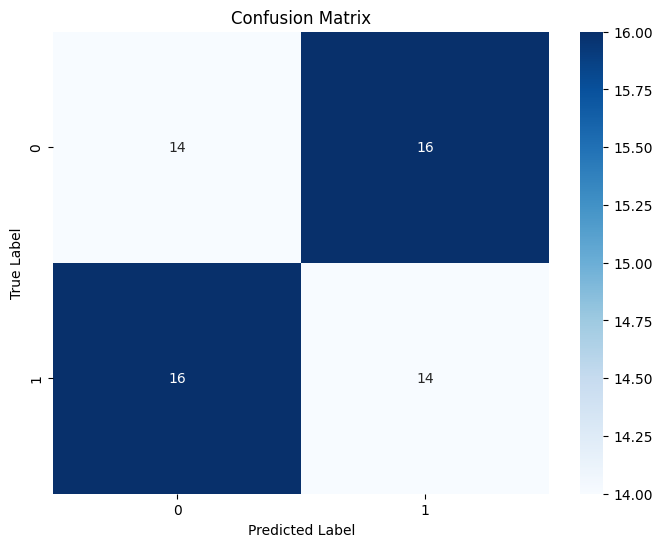

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns


# After training, you can evaluate the model on the test set and obtain predictions
y_true = validation_generator.classes
y_pred = model.predict(validation_generator)

# Convert predictions to binary values (0 or 1)
y_pred_binary = np.round(y_pred)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_binary)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
import cv2


# Load the image, replace with relevant image name
covid_image_name = 'sample_covid_image.png'


covid_img = cv2.imread(covid_image_name)
# Preprocess the image for Covid-19
covid_img = cv2.resize(covid_img, (224, 224))
covid_img = img.astype('float32') / 255.0
covid_img = np.expand_dims(covid_img, axis=0)

# Load the image, replace with relevant image names
pneumonia_image_name = 'sample_pneumonia_image.png'

pneumonia_img = cv2.imread(pneumonia_image_name)

pneumonia_img = cv2.resize(pneumonia_img, (224, 224))
pneumonia_img = img.astype('float32') / 255.0
pneumonia_img = np.expand_dims(pneumonia_img, axis=0)


# Load the trained model

# Make a prediction on the the covid-19 image
prediction_covid = model.predict(covid_img)

# Make a prediction on the the covid-19 image
prediction_pneumonia = model.predict(pneumonia_img)

# Interpret the output for Covid-19
if prediction_covid > 0.5:
    print('Covid +ve')
else:
    print('Covid -ve')


# Interpret the output for pneumonia
if prediction_pneumonia > 0.5:
    print('Pneumonia +ve')
else:
    print('Pneumonia -ve')
